In [1]:
import pandas as pd
import itertools
import numpy as np
import matplotlib.pyplot as plt

plt.style.use('Solarize_Light2')

pd.set_option('display.expand_frame_repr', False)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

import matplotlib
matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['text.color'] = 'k'
import seaborn as sns

import statsmodels.api as sm
from scipy.stats import boxcox
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tsa.seasonal import seasonal_decompose
from pandas.plotting import autocorrelation_plot

from datetime import timedelta
from math import sqrt
import random

from functions_air_quality_madrid import *

import os
print(os.listdir("/Users/yc00027/Documents/air-quality-madrid/"))

import warnings
warnings.filterwarnings("ignore")

['.DS_Store', 'csvs_per_year', 'stations.csv', 'madrid.h5', '.ipynb_checkpoints']


# Air quality Madrid - Stationarity Analysis

### Extracting the data

In [2]:
# Import the entire time series 

df_full = pd.read_csv('full_madrid_air_quality.csv').set_index('date').sort_index()
df_full.index = pd.to_datetime(df_full.index)

print(f'Full DF shape: {df_full.shape}')
df_full.head()

Full DF shape: (5923944, 18)


,BEN,CH4,CO,EBE,MXY,NMHC,NO,NO_2,NOx,OXY,O_3,PM10,PM25,PXY,SO_2,TCH,TOL,station
date,,,,,,,,,,,,,,,,,,
2001-01-01 01:00:00,NaN,NaN,1.23,NaN,NaN,NaN,NaN,55.750000,127.199997,NaN,8.38,44.950001,NaN,NaN,14.560000,NaN,NaN,28079017
2001-01-01 01:00:00,NaN,NaN,1.85,NaN,NaN,NaN,NaN,53.820000,123.699997,NaN,6.41,26.540001,NaN,NaN,35.720001,NaN,NaN,28079038
2001-01-01 01:00:00,2.13,NaN,0.87,1.44,3.16,NaN,NaN,53.400002,100.000000,1.06,8.35,36.669998,NaN,1.28,11.420000,NaN,7.04,28079025
2001-01-01 01:00:00,NaN,NaN,0.91,NaN,NaN,0.09,NaN,46.470001,74.919998,NaN,10.14,22.420000,NaN,NaN,41.770000,1.29,NaN,28079007
2001-01-01 01:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,28079001


In [3]:
# Select data for the particles of interest

particles_of_interest = ['NO_2', 'O_3', 'PM10', 'SO_2']

df_select = df_full[particles_of_interest + ['station']]

print(f'The particles of interest are {len(particles_of_interest)}: {particles_of_interest}')
print('')

# Select data for the stations of interest

percent_nulls_per_station = df_select.set_index('station').isnull().sum(axis=1).groupby('station') \
.apply(lambda x: x.sum()/(x.count() * 4) * 100).sort_values(ascending=False)

stations_of_interest = list(percent_nulls_per_station[percent_nulls_per_station.values < 40].index)

df_temp = df_select.loc[df_select['station'].isin(stations_of_interest)]

print(f'The stations of interest are {len(stations_of_interest)}: {stations_of_interest}')
print('')

# Select data for the time period of interest

first_date = '2012-01-01 00:00:00'
last_date = '2018-04-30 23:00:00'

df_temp = df_temp.loc[first_date:last_date].sort_index()

print(f'The time period is from {first_date} to {last_date}')
print('')

# Inspect resulting dataframe

print(f'Filtered DF shape: {df_temp.shape}')
print(f'Percentage of rows dropped: {round(100 - (df_temp.shape[0]/df_full.shape[0]*100))}%')
df_temp.head()

The particles of interest are 4: ['NO_2', 'O_3', 'PM10', 'SO_2']

The stations of interest are 12: [28079017, 28079011, 28079035, 28079039, 28079016, 28079004, 28079038, 28079036, 28079040, 28079008, 28079018, 28079024]

The time period is from 2012-01-01 00:00:00 to 2018-04-30 23:00:00

Filtered DF shape: (665856, 5)
Percentage of rows dropped: 89%


,NO_2,O_3,PM10,SO_2,station
date,,,,,
2012-01-01,92.0,NaN,NaN,NaN,28079011
2012-01-01,100.0,3.0,NaN,7.0,28079017
2012-01-01,111.0,2.0,NaN,NaN,28079016
2012-01-01,97.0,3.0,58.0,23.0,28079008
2012-01-01,104.0,3.0,NaN,12.0,28079035


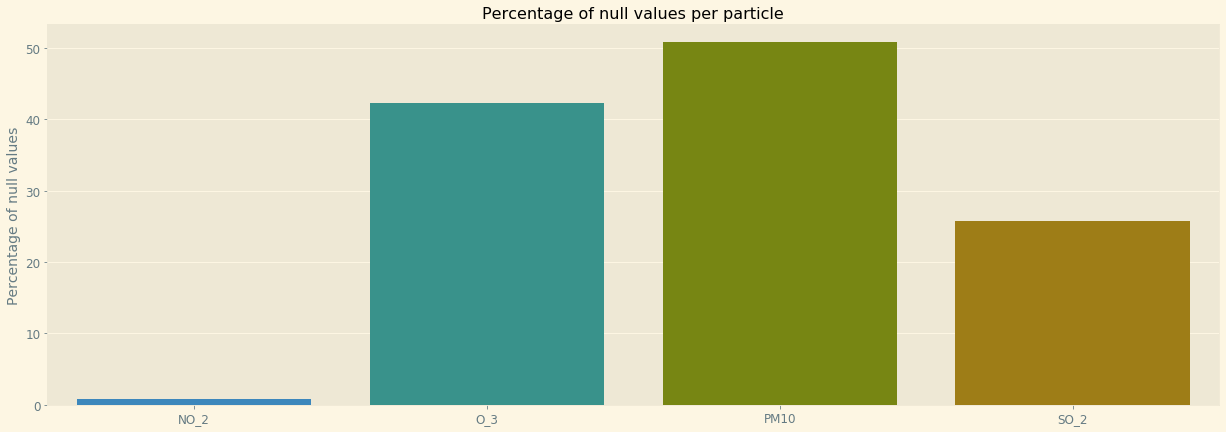

In [6]:
# Plot percentage of null values per column

fig, ax = plt.subplots(figsize=(21,7))

null_percentages = (df_temp[particles_of_interest].isnull().mean()*100).to_frame()
sns.barplot(x = null_percentages.index, y = null_percentages[0], data = null_percentages)
plt.title('Percentage of null values per particle')
plt.ylabel('Percentage of null values')
plt.show()

In [5]:
# Generate dataframe for one particle and one station of interest

particle_of_interest = 'NO_2'
station_of_interest = 28079038

oneparticle_onestation = df_temp.loc[df_temp['station'] == station_of_interest]
oneparticle_onestation = oneparticle_onestation.drop(columns = [x for x in particles_of_interest if x is not particle_of_interest], axis=1)
oneparticle_onestation.drop('station', axis=1, inplace=True)
oneparticle_onestation.fillna(method='ffill', inplace=True)

oneparticle_onestation['quarter'] = oneparticle_onestation.index.quarter
oneparticle_onestation['dayofyear'] = oneparticle_onestation.index.dayofyear
oneparticle_onestation['dayofmonth'] = oneparticle_onestation.index.day
oneparticle_onestation['weekyear'] = oneparticle_onestation.index.weekofyear
oneparticle_onestation['weekday'] = oneparticle_onestation.index.weekday
oneparticle_onestation['hour'] = oneparticle_onestation.index.hour
oneparticle_onestation['year'] = oneparticle_onestation.index.year
oneparticle_onestation['month'] = oneparticle_onestation.index.month
oneparticle_onestation.fillna(0, inplace=True)

print(f'DF shape: {oneparticle_onestation.shape}')
print(f'Missing values: {oneparticle_onestation[particle_of_interest].isnull().sum()}')
oneparticle_onestation.head()

DF shape: (55488, 9)
Missing values: 0


,NO_2,quarter,dayofyear,dayofmonth,weekyear,weekday,hour,year,month
date,,,,,,,,,
2012-01-01 00:00:00,71.0,1,1,1,52,6,0,2012,1
2012-01-01 01:00:00,87.0,1,1,1,52,6,1,2012,1
2012-01-01 02:00:00,128.0,1,1,1,52,6,2,2012,1
2012-01-01 03:00:00,124.0,1,1,1,52,6,3,2012,1
2012-01-01 04:00:00,63.0,1,1,1,52,6,4,2012,1


### Visualizing the target variable

Text(0, 0.5, 'NO_2')

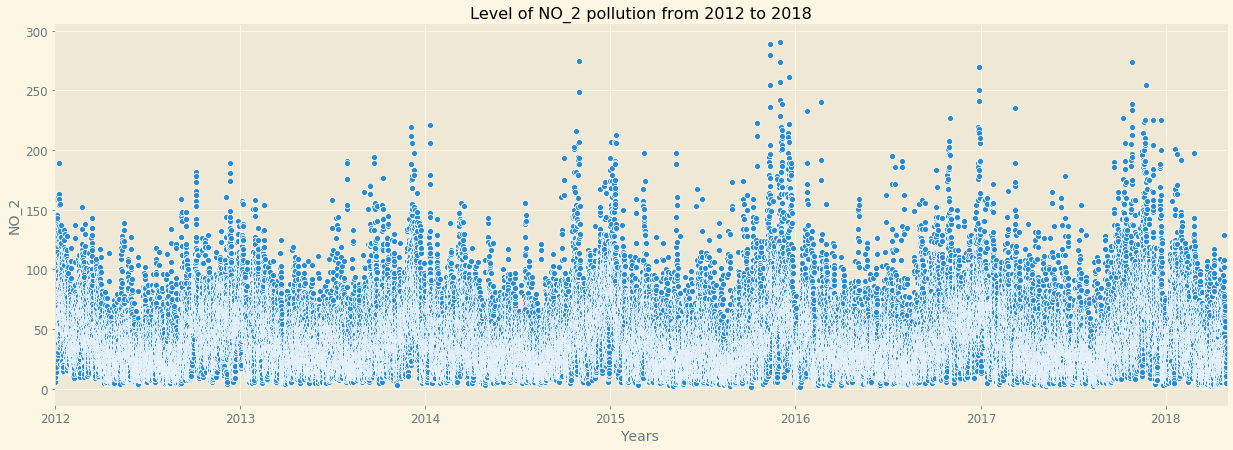

In [6]:
# Plot target variable

fig, ax = plt.subplots(figsize=(21,7))

sns.scatterplot(x = oneparticle_onestation.index, y = oneparticle_onestation[particle_of_interest])
ax.axes.set_xlim(oneparticle_onestation.index.min(), oneparticle_onestation.index.max())
plt.title(f'Level of {particle_of_interest} pollution from 2012 to 2018') 
plt.xlabel('Years')
plt.ylabel(particle_of_interest)

Text(0.5, 1.0, 'Distribution of NO_2 pollution levels')

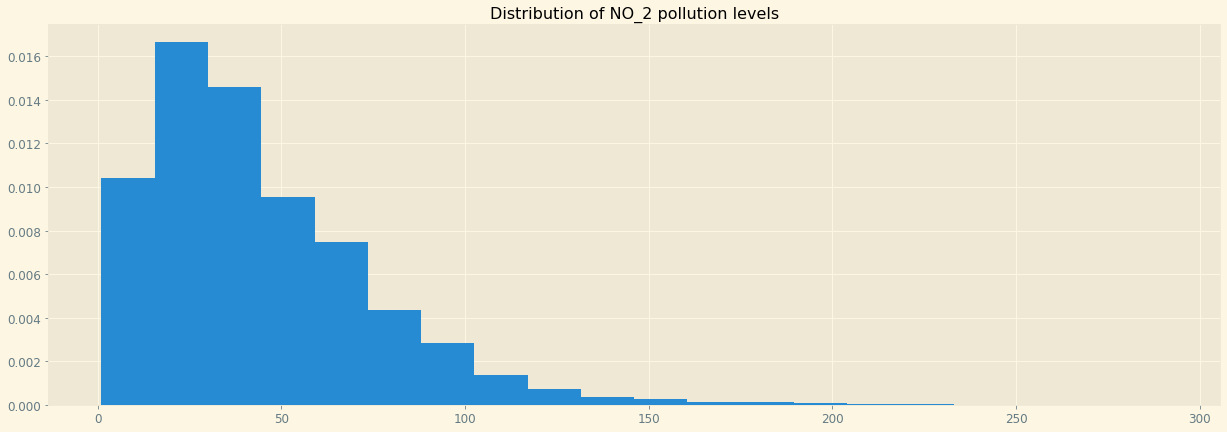

In [7]:
# Plot the distribution target variable

fig, ax = plt.subplots(figsize=(21,7))

oneparticle_onestation[particle_of_interest].hist(density=True, bins = 20)
plt.title(f'Distribution of {particle_of_interest} pollution levels') 

__Reviewing plots of the density of observations can provide further insight into the structure of the data:__
- The distribution is not normal.
- The distribution is left shifted.
- Transformations might be useful prior to modelling.

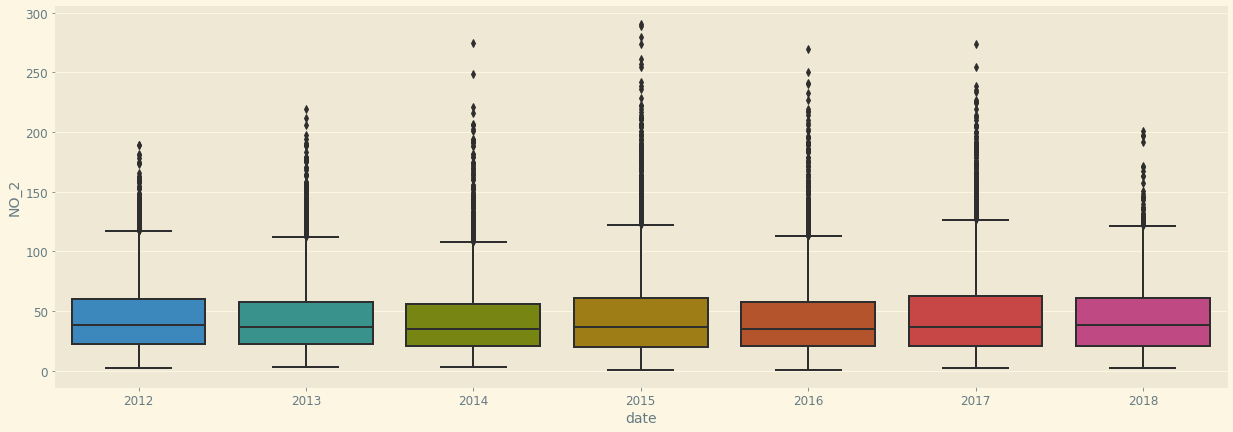

In [8]:
# Plot the range and year on year variability of the target variable 

fig, ax = plt.subplots(figsize=(21,7))

sns.boxplot(oneparticle_onestation.index.year, oneparticle_onestation[particle_of_interest])

__Box and Whisker Plots:__
- Median values and spread across years do not show any significant trend

### Decomposition of the time series data

- **Additive Model**

An additive model suggests that the components are added together as follows:

y(t) = Level + Trend + Seasonality + Noise

An additive model is linear where changes over time are consistently made by the same amount. A linear trend is a straight line

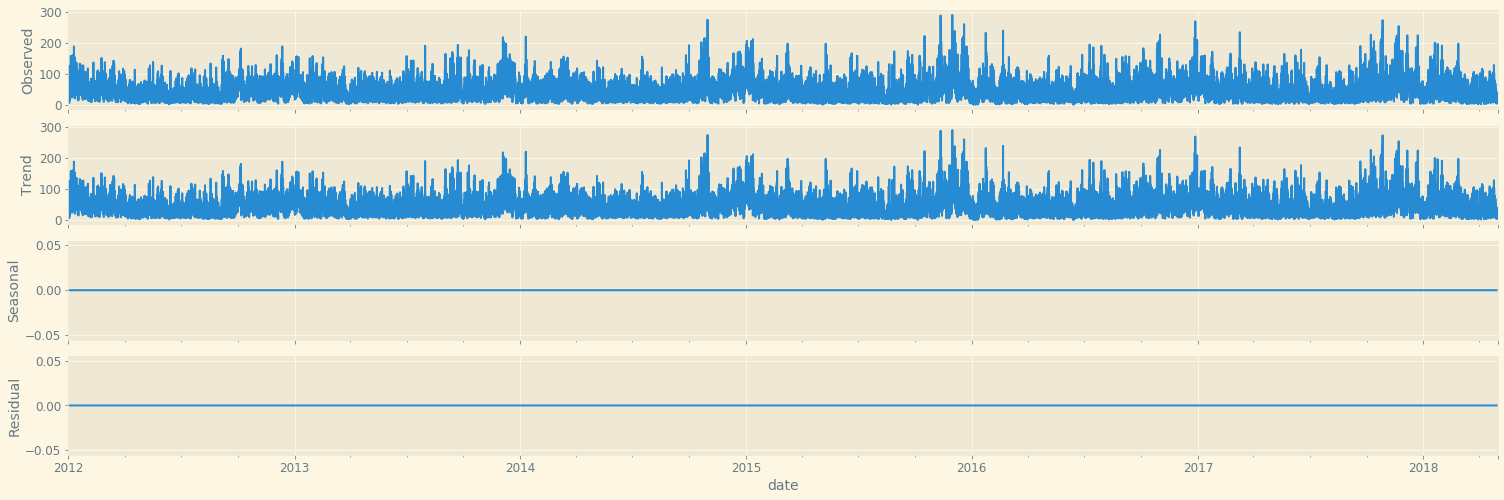

In [9]:
# Plot the decomposition of the target variable with an additive model

from pylab import rcParams
rcParams['figure.figsize'] = 21, 7
decomposition = seasonal_decompose(oneparticle_onestation[particle_of_interest], model='additive', freq=1)
fig = decomposition.plot()
plt.show()


- **Multiplicative Model**

A multiplicative model suggests that the components are multiplied together as follows:

y(t) = Level * Trend * Seasonality * Noise


A multiplicative model is nonlinear, such as quadratic or exponential. Changes increase or decrease over time. A nonlinear trend is a curved line.

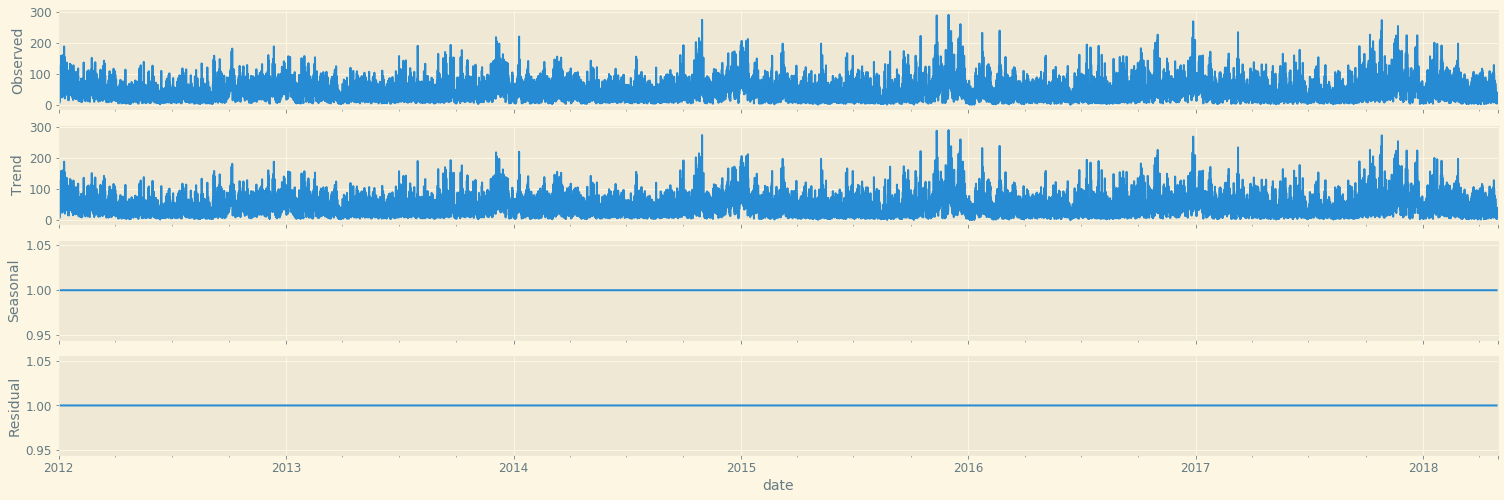

In [10]:
# Plot the decomposition of the target variable with a multiplicative model

from pylab import rcParams
rcParams['figure.figsize'] = 21, 7
decomposition = seasonal_decompose(oneparticle_onestation[particle_of_interest], model='multiplicative', freq=1)
fig = decomposition.plot()
plt.show()

### Establishing stationarity

#### ACF and PACF plots

**Auto correlation function (ACF)** is an (complete) auto-correlation function which gives us values of auto-correlation of any series with its lagged values. In simple terms, it describes how well the present value of the series is related with its past values. A time series can have components like trend, seasonality, cyclic and residual. ACF considers all these components while finding correlations hence it’s a ‘complete auto-correlation plot’


The **partial autocorrelation function (PACF)** gives the partial correlation of a stationary time series with its own lagged values, regressed the values of the time series at all shorter lags. It contrasts with the autocorrelation function, which does not control for other lags.

 > If the time series is stationary, the ACF/PACF plots will show a __quick drop-off in correlation__ after a small amount of lag between points.

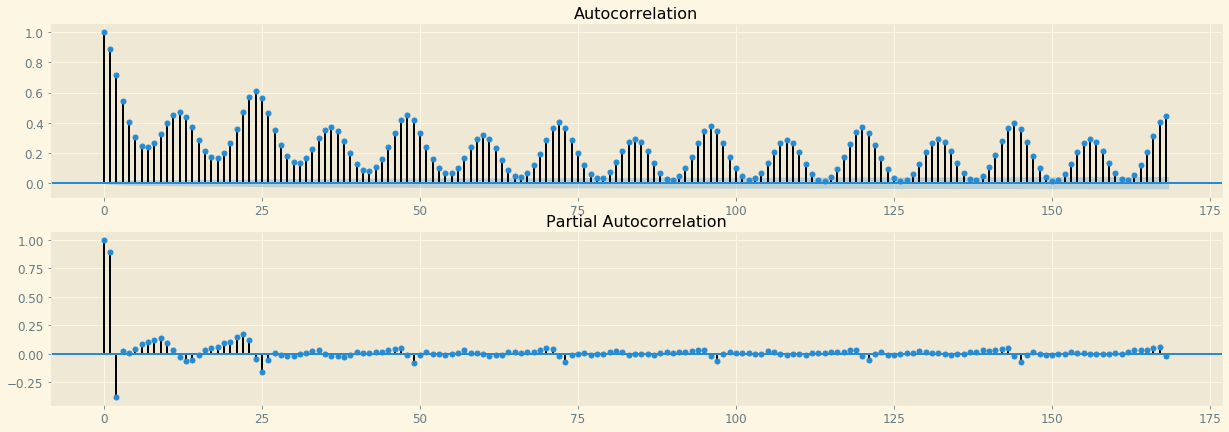

In [11]:
# Plot the autocorrelation and partial autocorrelation functions for the target variable

plt.figure(figsize=(21,7))
plt.subplot(211)
plot_acf(oneparticle_onestation[particle_of_interest], ax=plt.gca(), lags = 24*7)
plt.subplot(212)
plot_pacf(oneparticle_onestation[particle_of_interest], ax=plt.gca(), lags = 24*7)
plt.show()

### Interpreting ACF plots


ACF Shape	| Indicated Model |
-- | -- |
Exponential, decaying to zero |	Autoregressive model. Use the partial autocorrelation plot to identify the order of the autoregressive model |
Alternating positive and negative, decaying to zero	Autoregressive model. |  Use the partial autocorrelation plot to help identify the order. |
One or more spikes, rest are essentially zero | Moving average model, order identified by where plot becomes zero. |
Decay, starting after a few lags |	Mixed autoregressive and moving average (ARMA) model. | 
All zero or close to zero | Data are essentially random. |
High values at fixed intervals | Include seasonal autoregressive term. |
No decay to zero |	Series is not stationary |

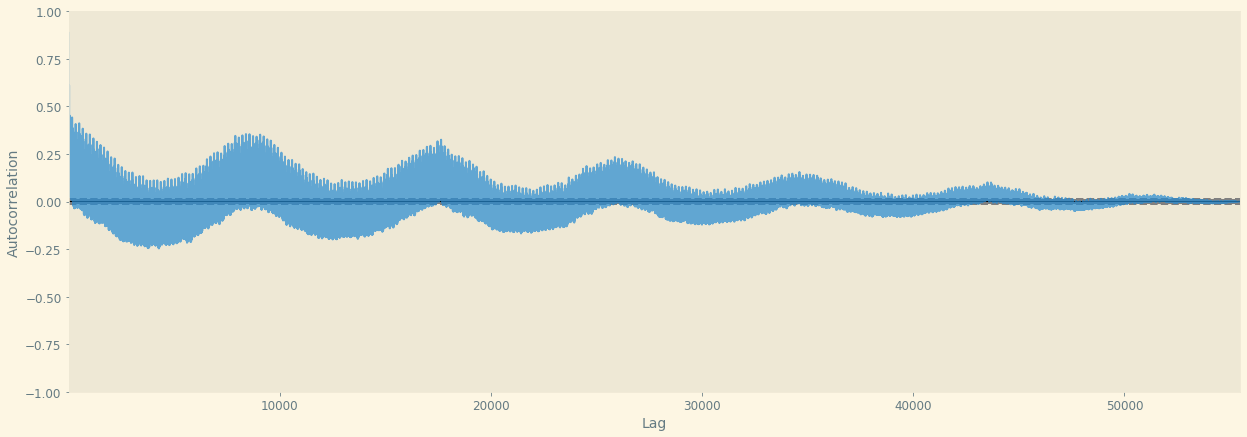

In [12]:
# Plot the autocorrelation for the target variable

autocorrelation_plot(oneparticle_onestation[particle_of_interest], alpha=0.7)

#### Dickey-Fuller Test, KPSS test and rolling statistics

#### Augmented Dickey-Fuller
The null hypothesis for this test is that there is a unit root. The alternative hypothesis is that the time series is stationary, or trend stationary. If the test statistic is less than the critical Value, we can reject the null hypothesis and say that the series is stationary. Additionally, if the p-value is less than alpha we can reject the null hypothesis.


#### KPSS
KPSS figures out if a time series is stationary around a mean or linear trend. The null hypothesis is that the data is stationary, the alternate hypothesis for the test is that the data is not stationary.

To interpret, if the test statistic is greater than the critical values then the null hypothesis is rejected and the series is non-stationary. We can also use the returned p-value and compare it to the alpha level, where if the p-value is less than our alpha we reject the null hypothesis.

If we fail to reject the null hypothesis it means our time series is stationary or trend stationary, because KPSS classifies a series as stationary on the absence of a unit root.

Because there are several types of stationary we can use KPSS and ADF in conjunction to determine what transformations to make. If KPSS = Stationary and ADF = Not Stationary then our time series is trend stationary and we need to remove the trend to be strict stationary. If KPSS = Not Stationary and ADF = Stationary then our time series is difference stationary, and we need to difference our series.

Stationarity Tests:
Original target:
Results of Dickey-Fuller Test:
Null Hypothesis: Unit Root Present
Test Statistic < Critical Value => Reject Null
P-Value =< Alpha(.05) => Reject Null

Test Statistic                -1.708995e+01
p-value                        7.603025e-30
#Lags Used                     5.700000e+01
Number of Observations Used    5.543000e+04
Critical Value 1%             -3.430468e+00
Critical Value 5%             -2.861592e+00
Critical Value 10%            -2.566798e+00
dtype: float64 

Results of KPSS Test:
Null Hypothesis: Data is Stationary/Trend Stationary
Test Statistic > Critical Value => Reject Null
P-Value =< Alpha(.05) => Reject Null

Test Statistic          0.599214
p-value                 0.022708
Lags Used              59.000000
Critical Value 10%      0.347000
Critical Value 5%       0.463000
Critical Value 2.5%     0.574000
Critical Value 1%       0.739000
dtype: float64 



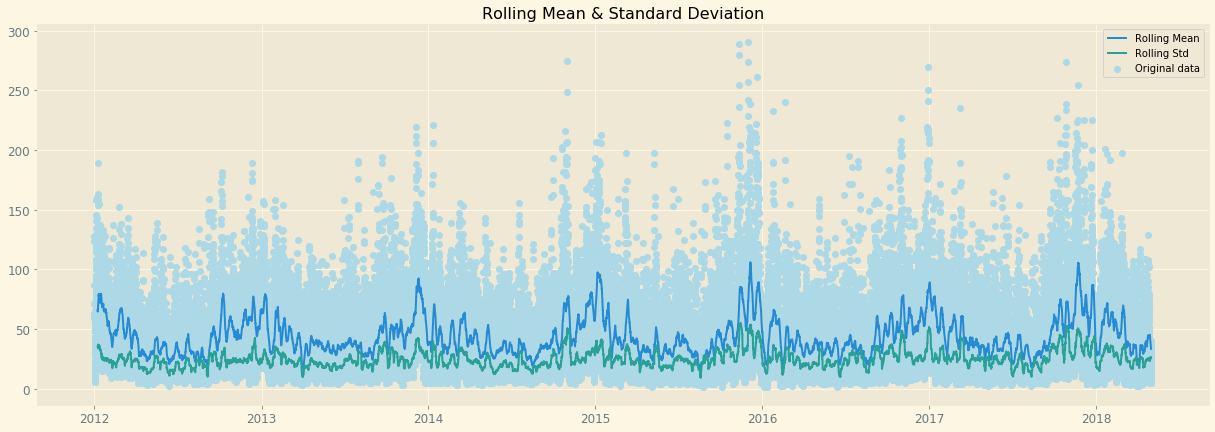

In [13]:
# Apply stationarity tests to the original target variable

print('Stationarity Tests:')
print('Original target:')
adf_test(oneparticle_onestation[particle_of_interest])
kpss_test(oneparticle_onestation[particle_of_interest])

plot_rolling_statistics(oneparticle_onestation[particle_of_interest])

### Transforming the target variable

Text(0, 0.5, 'NO_2')

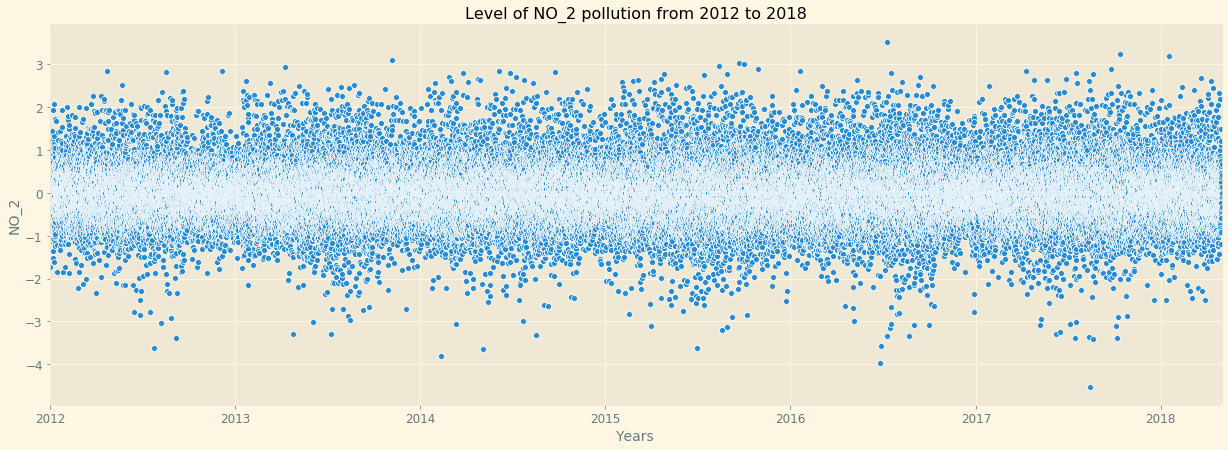

In [14]:
# Apply transformations to target variable

oneparticle_onestation['diff_particle'] = oneparticle_onestation[particle_of_interest].diff()
oneparticle_onestation['bc_particle'], lamb = boxcox(oneparticle_onestation[particle_of_interest])
oneparticle_onestation['bc_diff_particle'] = oneparticle_onestation['bc_particle'].diff()
oneparticle_onestation.fillna(0, inplace=True)

# Plot the transformed target variable

fig, ax = plt.subplots(figsize=(21,7))

sns.scatterplot(x = oneparticle_onestation.index, y = oneparticle_onestation['bc_diff_particle'])
ax.axes.set_xlim(oneparticle_onestation.index.min(), oneparticle_onestation.index.max())
plt.title(f'Level of {particle_of_interest} pollution from 2012 to 2018') 
plt.xlabel('Years')
plt.ylabel(particle_of_interest)

Text(0.5, 1.0, 'Distribution of NO_2 pollution levels')

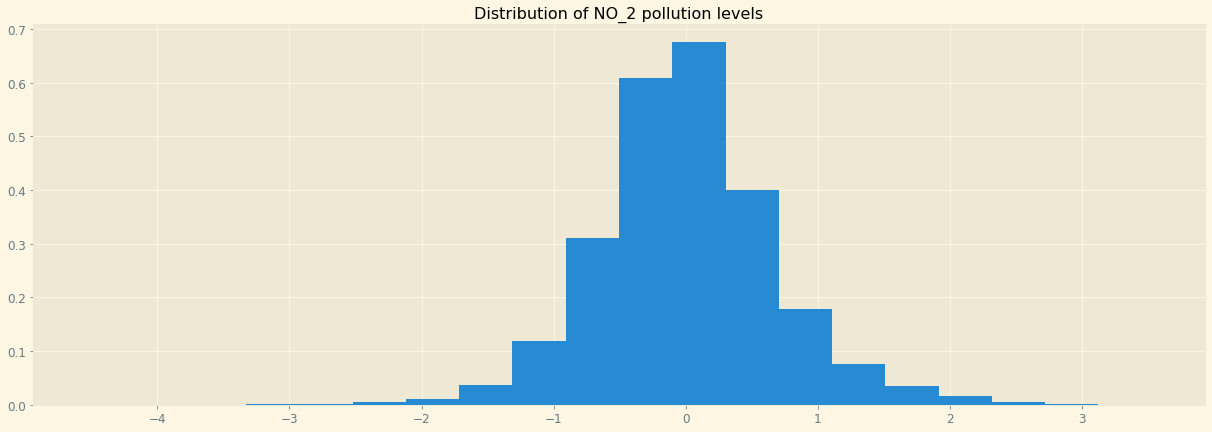

In [15]:
# Plot the distribution target variable

fig, ax = plt.subplots(figsize=(21,7))

oneparticle_onestation['bc_diff_particle'].hist(density=True, bins = 20)
plt.title(f'Distribution of {particle_of_interest} pollution levels') 

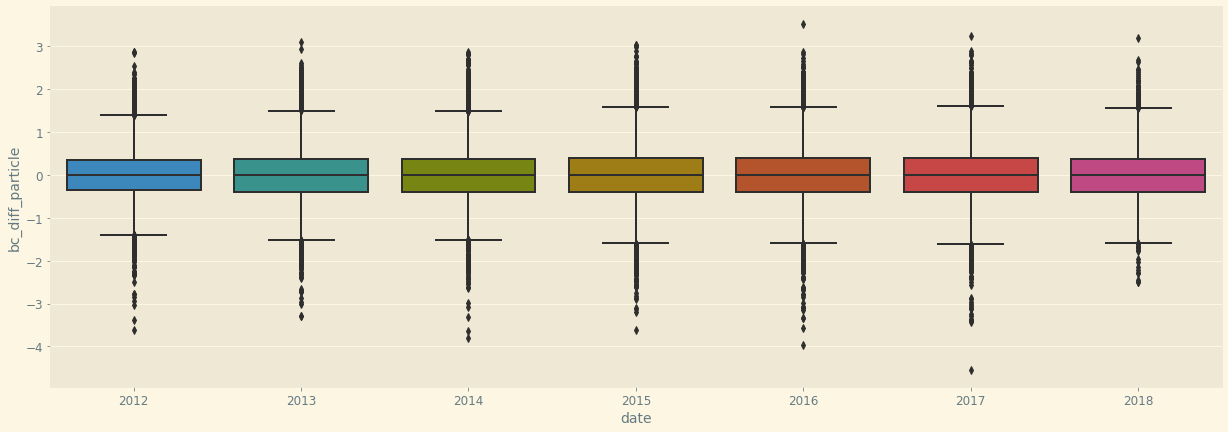

In [16]:
# Plot the range and year on year variability of the target variable 

fig, ax = plt.subplots(figsize=(21,7))

sns.boxplot(oneparticle_onestation.index.year, oneparticle_onestation['bc_diff_particle'])

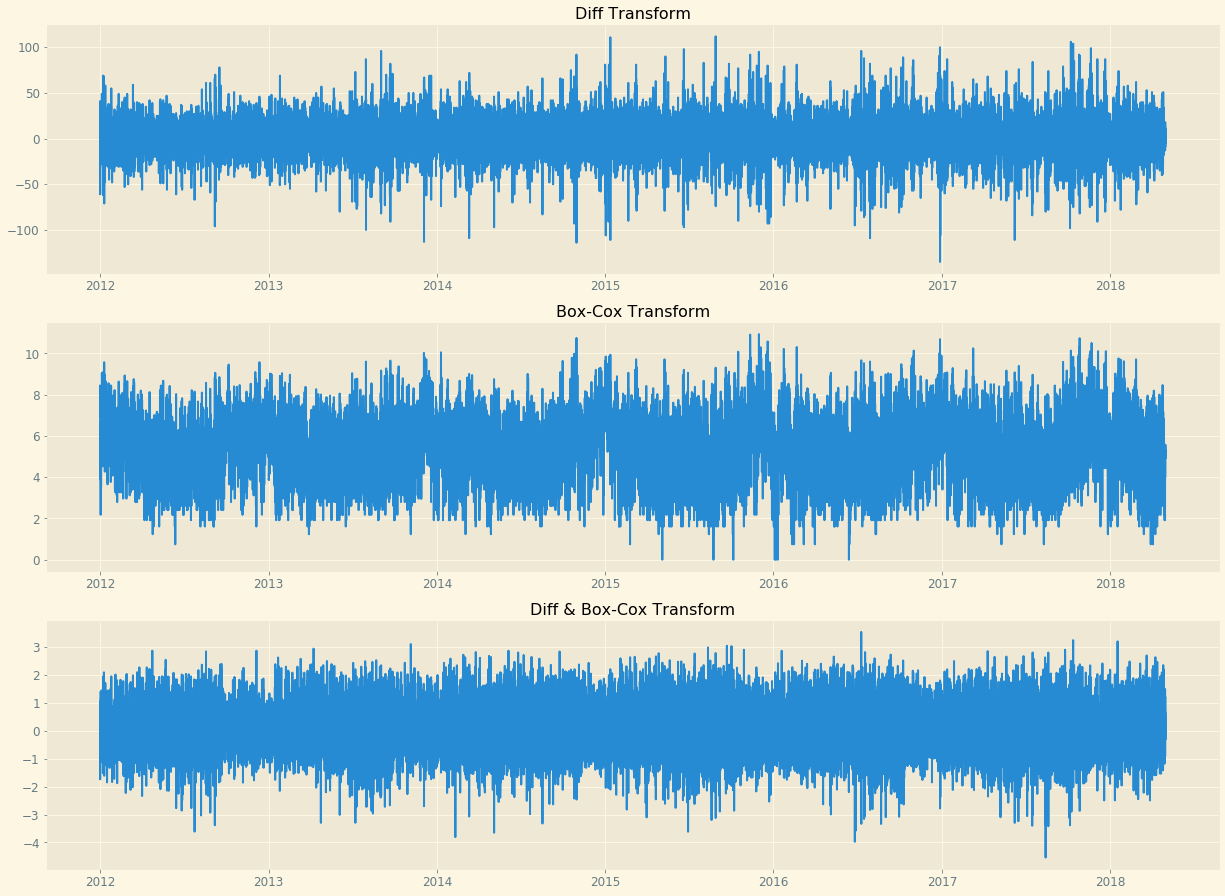

Unit Root Tests:
Difference:
Results of Dickey-Fuller Test:
Null Hypothesis: Unit Root Present
Test Statistic < Critical Value => Reject Null
P-Value =< Alpha(.05) => Reject Null

Test Statistic                   -40.929861
p-value                            0.000000
#Lags Used                        59.000000
Number of Observations Used    55428.000000
Critical Value 1%                 -3.430468
Critical Value 5%                 -2.861592
Critical Value 10%                -2.566798
dtype: float64 

Results of KPSS Test:
Null Hypothesis: Data is Stationary/Trend Stationary
Test Statistic > Critical Value => Reject Null
P-Value =< Alpha(.05) => Reject Null

Test Statistic          0.000997
p-value                 0.100000
Lags Used              59.000000
Critical Value 10%      0.347000
Critical Value 5%       0.463000
Critical Value 2.5%     0.574000
Critical Value 1%       0.739000
dtype: float64 

BoxCox-No Difference
Results of Dickey-Fuller Test:
Null Hypothesis: Unit Root Present


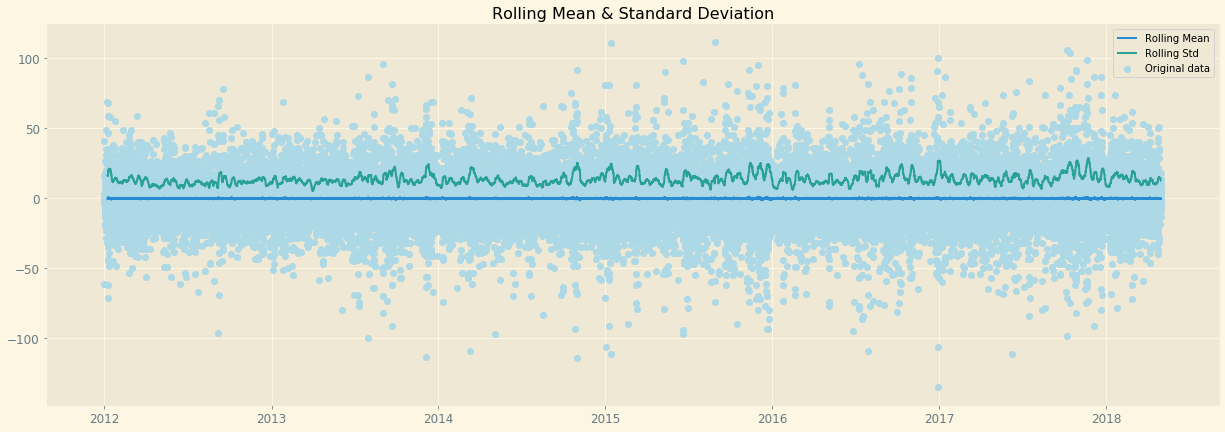

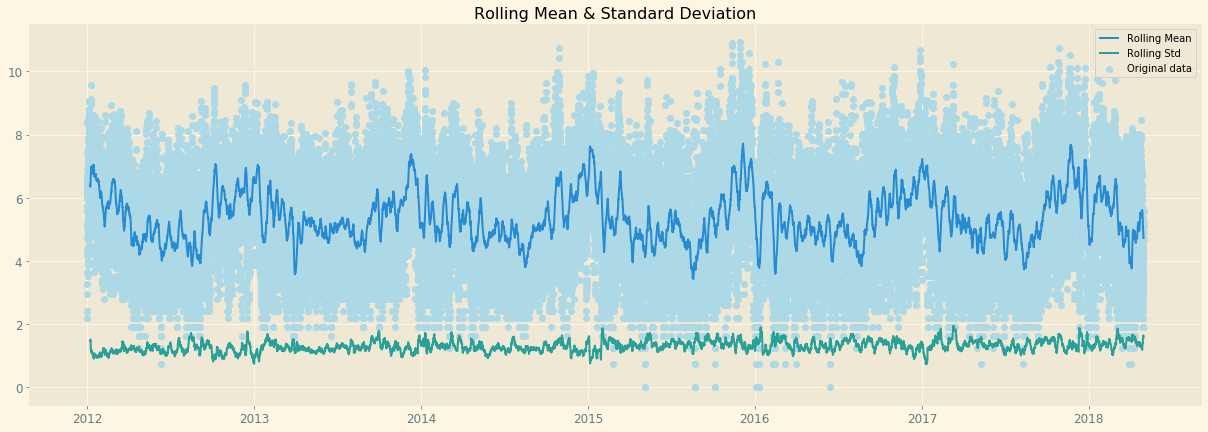

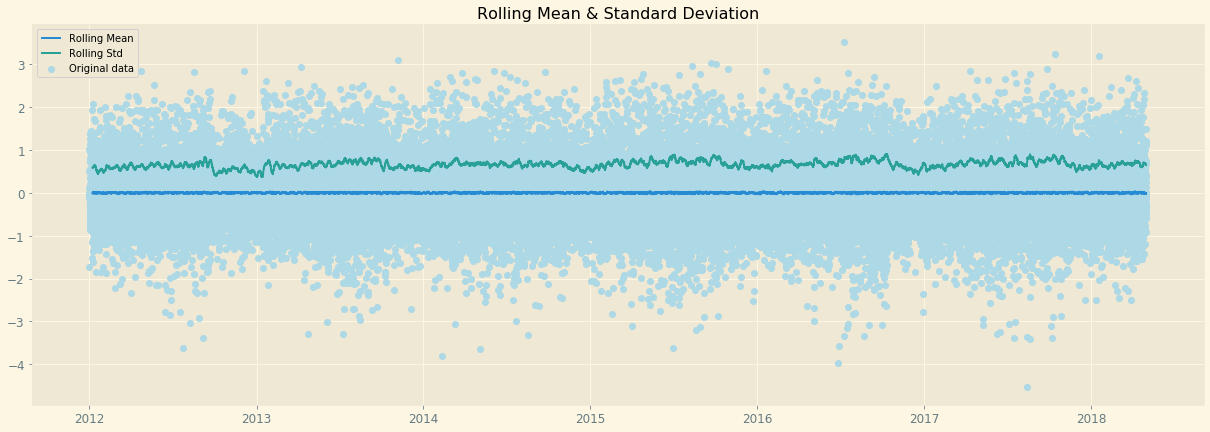

In [17]:
# Test stationarity of the transformed target variable

fig = plt.figure(figsize=(21,21))

plt_bc = plt.subplot(411)
plt_bc.plot(oneparticle_onestation['diff_particle'])
plt_bc.title.set_text('Diff Transform')
plt_bc = plt.subplot(412)
plt_bc.plot(oneparticle_onestation['bc_particle'])
plt_bc.title.set_text('Box-Cox Transform')
plt_d1 = plt.subplot(413)
plt_d1.plot(oneparticle_onestation['bc_diff_particle'])
plt_d1.title.set_text('Diff & Box-Cox Transform')
plt.show()

print('Unit Root Tests:')
print('Difference:')
adf_test(oneparticle_onestation['diff_particle'])
kpss_test(oneparticle_onestation['diff_particle'])
print('BoxCox-No Difference')
adf_test(oneparticle_onestation['bc_particle'])
kpss_test(oneparticle_onestation['bc_particle'])
print('Difference & BoxCox:')
adf_test(oneparticle_onestation['bc_diff_particle'])
kpss_test(oneparticle_onestation['bc_diff_particle'])

plot_rolling_statistics(oneparticle_onestation['diff_particle'])
plot_rolling_statistics(oneparticle_onestation['bc_particle'])
plot_rolling_statistics(oneparticle_onestation['bc_diff_particle'])

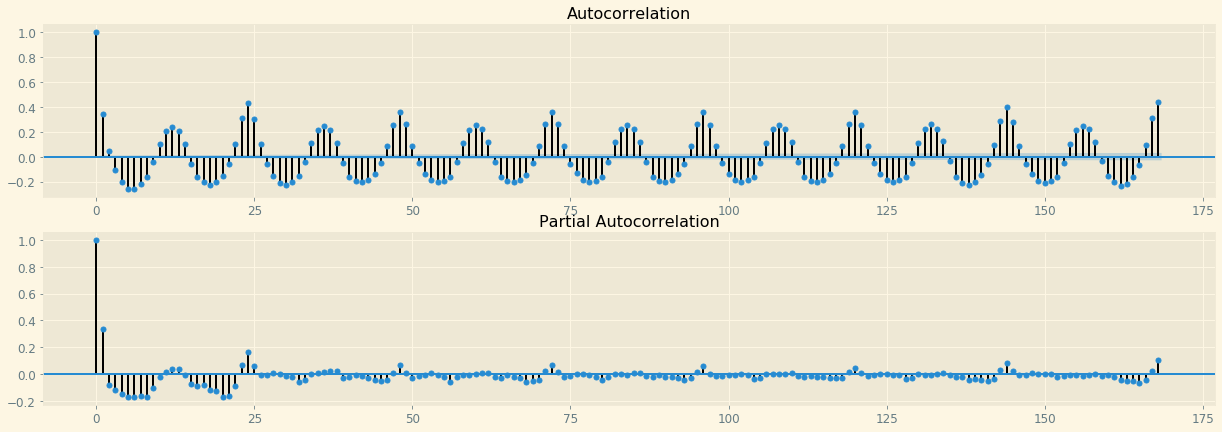

In [18]:
# Plot the autocorrelation and partial autocorrelation functions for the transformed target variable

plt.figure(figsize=(21,7))
plt.subplot(211)
plot_acf(oneparticle_onestation['bc_diff_particle'], ax=plt.gca(), lags = 24*7)
plt.subplot(212)
plot_pacf(oneparticle_onestation['bc_diff_particle'], ax=plt.gca(), lags = 24*7)
plt.show()

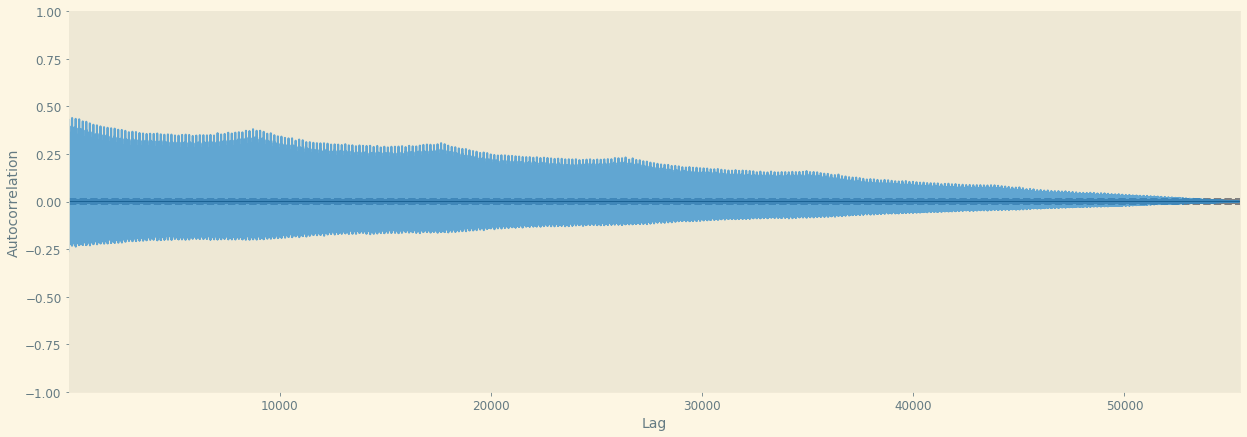

In [19]:
# Plot the autocorrelation for the target variable

autocorrelation_plot(oneparticle_onestation['bc_diff_particle'], alpha=0.7)